# Задание к модулю "Предиктивная аналитика в ИБ"
Необходимо определить аномалии в данных технологического процесса, которые были спровоцированы сетевой атакой.

## Исходные данные

Анализируемые данные - данные технологического процесса, полученные на полигоне SWaT (Secure Water Treatment). Данный полигон – это водоочистительный полигон для исследований в области кибербезопасности. SWaT был запущен в 2015 году Центром исследований кибербезопасности iTrust Сингапурского университета технологий и дизайна при финансовой поддержке министерства обороны Сингапура. На нем исследуют возможные векторы атак на промышленные объекты и разрабатывают подтвержденные практикой рекомендации по защите объектов критически важных инфраструктур.

Виртуальный тур по полигону: https://www.youtube.com/watch?v=2r1ctjULCnI

Сайт полигона: https://itrust.sutd.edu.sg/testbeds/secure-water-treatment-swat/

Информация по датасету: https://itrust.sutd.edu.sg/itrust-labs_datasets/dataset_info/

В качестве исходных данных взята атака, произведенная в 2015 году

## Задачи
1. Основные задачи. Определить аномалии в исходном датасете несколькими способами
- OneClassSVM
- Autoencoder
- Self-Orginized-Map

2. Задачи для самостоятельной работы и исследования. 
- Применить метод LOF для поиска аномалий
- Произвести корневой анализ причин длительной аномалии

# Основная часть

### Импорт библиотек

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.gridspec import GridSpec
import scipy.spatial.distance as distance
import sklearn, scipy
from sklearn.svm import OneClassSVM 
from sklearn.neighbors import LocalOutlierFactor
from sklearn import preprocessing
from sklearn.metrics import f1_score, accuracy_score, precision_score, recall_score
from tensorflow import keras
from tensorflow.keras.optimizers import SGD
from tensorflow.keras import Model
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Input, TimeDistributed, Dropout
from tqdm import tqdm


Версии библиотек и Python:

In [2]:
!python3 --version

Python 3.9.2


In [3]:
print(f'Pandas: {pd.__version__:}')
print(f'Numpy: {np.__version__:}')
print(f'Sklearn: {sklearn.__version__:}')
print(f'TensorFlow: {keras.__version__:}')
print(f'Scipy: {scipy.__version__:}')

Pandas: 1.2.3
Numpy: 1.19.5
Sklearn: 0.24.1
TensorFlow: 2.6.0
Scipy: 1.7.2


### Загрузка и первичный анализ данных

In [4]:
raw_data = pd.read_csv('2015_labeled_and_time_normalize.csv').drop(['Unnamed: 0', 'Timestamp'], axis=1)
raw_data

,FIT101,LIT101,MV101,P101,P102,AIT201,AIT202,AIT203,FIT201,MV201,...,P501,P502,PIT501,PIT502,PIT503,FIT601,P601,P602,P603,Normal/Attack
0,2.427057,522.8467,2,2,1,262.0161,8.396437,328.6337,2.445391,2,...,2,1,250.8652,1.649953,189.5988,0.000128,1,1,1,0.0
1,2.446274,522.8860,2,2,1,262.0161,8.396437,328.6337,2.445391,2,...,2,1,250.8652,1.649953,189.6789,0.000128,1,1,1,0.0
2,2.489191,522.8467,2,2,1,262.0161,8.394514,328.6337,2.442316,2,...,2,1,250.8812,1.649953,189.6789,0.000128,1,1,1,0.0
3,2.534350,522.9645,2,2,1,262.0161,8.394514,328.6337,2.442316,2,...,2,1,250.8812,1.649953,189.6148,0.000128,1,1,1,0.0
4,2.569260,523.4748,2,2,1,262.0161,8.394514,328.6337,2.443085,2,...,2,1,250.8812,1.649953,189.5027,0.000128,1,1,1,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
449914,2.559972,519.5495,2,2,1,168.0979,8.638683,301.9226,2.459488,2,...,2,1,251.1535,0.865024,189.0220,0.000000,1,1,1,0.0
449915,2.549082,520.4131,2,2,1,168.0979,8.638683,301.9226,2.459488,2,...,2,1,251.0734,0.865024,188.9259,0.000000,1,1,1,0.0
449916,2.531467,520.6878,2,2,1,168.0979,8.638683,301.9226,2.460129,2,...,2,1,251.0734,0.865024,188.9259,0.000000,1,1,1,0.0
449917,2.521218,520.7271,2,2,1,168.0979,8.638683,301.9226,2.460129,2,...,2,1,251.0734,0.865024,188.9259,0.000000,1,1,1,0.0


In [5]:
headers = raw_data.columns
headers

Index(['FIT101', 'LIT101', ' MV101', 'P101', 'P102', ' AIT201', 'AIT202',
       'AIT203', 'FIT201', ' MV201', ' P201', ' P202', 'P203', ' P204', 'P205',
       'P206', 'DPIT301', 'FIT301', 'LIT301', 'MV301', 'MV302', ' MV303',
       'MV304', 'P301', 'P302', 'AIT401', 'AIT402', 'FIT401', 'LIT401', 'P401',
       'P402', 'P403', 'P404', 'UV401', 'AIT501', 'AIT502', 'AIT503', 'AIT504',
       'FIT501', 'FIT502', 'FIT503', 'FIT504', 'P501', 'P502', 'PIT501',
       'PIT502', 'PIT503', 'FIT601', 'P601', 'P602', 'P603', 'Normal/Attack'],
      dtype='object')

Перед началом анализа важно внимательно ознакомиться с датасетом, убрать лишние признаки. Но самое главное - определить, что для нас является аномалией, а еще лучше - понять ее природу.

В нашем случае в датасете уже есть разметка принадлежности отсчета к аномалии: "Normal/Attack". Не всегда чьей то разметке стоит 100% доверять, но в данном примере мы будем.

Посмотрим на данные в виде графиков, отметим при этом аномалии красным цветом.

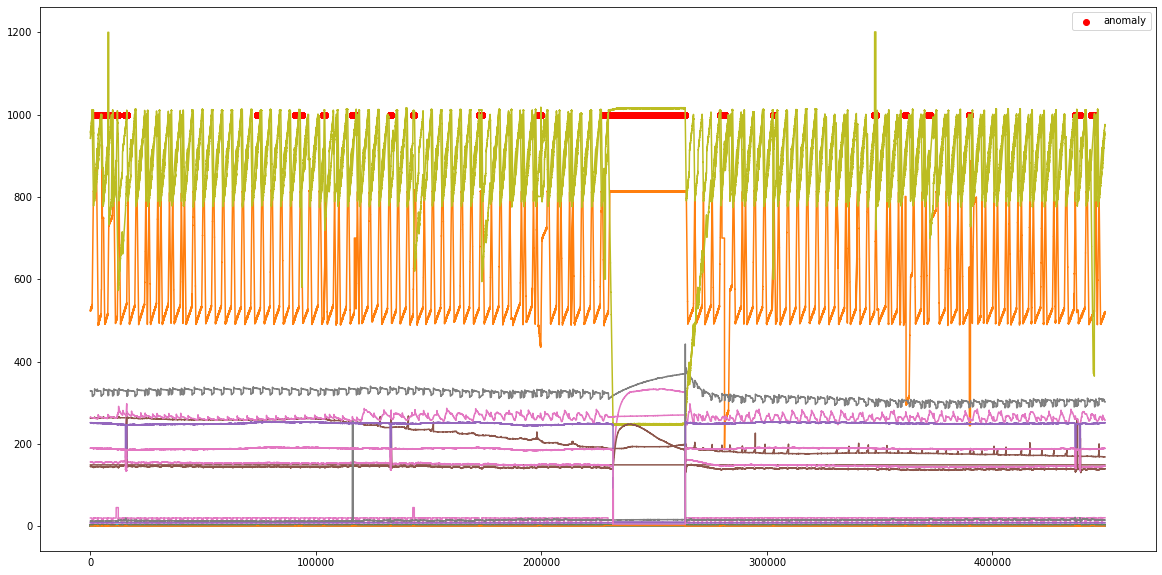

In [6]:
anomaly_data = raw_data[raw_data['Normal/Attack']==1]

plt.figure(figsize = (20,10))
plt.plot(raw_data)
plt.scatter(anomaly_data.index, [1000]*len(anomaly_data), c='r', label='anomaly')
plt.legend()
plt.show()

Наша цель - научиться определять аномалии разными методами, а в случае с длительной аномалией - найти ее первопричину.

### Подготовка данных

Скопируем датасет и выделим из него разметку

In [7]:
data = raw_data.copy()

label = data.pop('Normal/Attack')
anomaly_idxs = label[label==1].index
print('Количество аномалий:', int(label.sum()))

Количество аномалий: 54621


Для качественного анализа необходимо нормализовать данные, для этого используем модуль preprocessing от Sklearn

In [8]:
# Нормализация
scaled_data = preprocessing.normalize(data)
normalized_data =  pd.DataFrame(scaled_data, columns=data.columns)

## Обучение

Создадим тренировочный и тестовый датасет. Тренировать модели будем на первой половине датасета (до 220_000 сэмпла, а проверять будем на второй половине)

In [9]:
# Индекс, по которому будет производиться раздел
train_split_idx = 220_000 

# Данные для обучения (без аномалий)
x_train = normalized_data.drop(anomaly_idxs, axis=0).loc[:train_split_idx]

# Данные для тестирования (с аномалиями)
x_test = normalized_data[train_split_idx:]
y_test = label[train_split_idx:]

In [10]:
# Проверим распределение аномалий в тренировочном и тестовом датасете
anom_train = str(int(sum(label[:train_split_idx])/len(label)*100))+"%"
anom_test = str(int(sum(label[train_split_idx:])/len(label)*100))+"%"

print("Тренировочный датасет\n", anom_train, '\n', label[:train_split_idx].value_counts())
print("Тестовый датасет\n", anom_test, '\n', label[train_split_idx:].value_counts())


Тренировочный датасет
 2% 
 0.0    208243
1.0     11757
Name: Normal/Attack, dtype: int64
Тестовый датасет
 9% 
 0.0    187055
1.0     42864
Name: Normal/Attack, dtype: int64


В тестовом датасете больше аномалий, кроме того, выборка в принципе не сбалансирована. Классифицировать несбалансированную выборку сложно - недостаточно данных, поэтому нам нужны методы обучения без учителя или с частничным участием учителя.

### OneClassSVM

Применим для выявления аномалий одну из разновидностей метода опорных векторов One Class SVM, которая используется в случае, если нам достаточно разделить данные на две части, например, когда в выборке слишком мало аномальных данных. Если мы хотим научиться распознавать аномалии, обучая модель на данных без аномалий, то этот способ должен подойти.

Подробнее об SVM можно почитать в интернете, это очень популярный метод. Например, здесь: https://habr.com/ru/post/428503/

Кроме того, можно посмотреть статью конкретно по SWAT: https://www.researchgate.net/publication/305809559_A_Dataset_to_Support_Research_in_the_Design_of_Secure_Water_Treatment_Systems, https://arxiv.org/pdf/1709.05342.pdf

**Возможное задание** Найти причину, почему не вычисляется функция calc_score (дальше в задании) или вычисляется некорректно, написать функцию предобработки. Потому что модель возвращает не 0 и 1(аномалия), а -1 и 1, где 1-не аномалия

In [11]:
# Определим функцию для вывода основных метрик классификации, она нам понадобится в дальнейшем
def calc_score(y_test, y_pred, desc=''):
    f1_score_ = f1_score(y_test, y_pred)
    accuracy_score_ = accuracy_score(y_test, y_pred)
    precision_score_ = precision_score(y_test, y_pred)
    recall_score_ = recall_score(y_test, y_pred)
    
    if len(desc)!=0: # Если задано описание, то выводим данные только на экран
        print(desc)
        print(f'f1_score: {f1_score_:0.2f}')
        print(f'accuracy_score: {accuracy_score_:0.2f}')
        print(f'precision_score: {precision_score_:0.2f}')
        print(f'recall_score: {recall_score_:0.2f}')   
    else:
        return {'f1_score':f1_score_,'accuracy_score':accuracy_score_,
                'precision_score':precision_score_,'recall_score':recall_score_,}

# Определим функцию, которая будет нам возвращать индексы аномалий в списке
def calc_anomaly_idxs(label, idx_offset=0):
    idxs=[]
    for item,i in zip(label,range(len(label))):
        if item==1: idxs.append(i+idx_offset)
    
    return idxs

# Определим функцию для результатов работы некоторых моделей, которые возвращают -1 если сэмпл аномальный и 1 если неаномальный
def prepare_predict(predict):
# функция приводит ответ модели к виду из дата сета: 0 - нет аномалии, 1 - аномалия
    out=[]
    for i in range(len(predict)):
        out.append(int(predict[i] != 1))
    
    return out

# Функция отрисовки графика нам часто будет нужна, определим ее
def show_dataset_with_AD(AD_labels, AD_type):
    plt.figure(figsize = (20,10))

    anomaly_idxs = calc_anomaly_idxs(AD_labels)

    plt.plot(raw_data)
    plt.scatter(anomaly_data.index, 
                [1000]*len(anomaly_data), c='r', label='anomaly')
    plt.scatter(anomaly_idxs, 
                [1020]*len(anomaly_idxs), c='blue', label=AD_type)
    plt.legend()
    plt.show()

Определим нашу модель, коэффициенты взяты из статьи https://arxiv.org/pdf/1709.05342.pdf

In [12]:
svm = OneClassSVM(nu=0.00458, kernel="rbf", gamma=0.0008, verbose=True)

Обучим модель и применим ее к тестовым данным

In [13]:
svm.fit(x_train.values)
svm_predict = prepare_predict(svm.predict(x_test.values))

[LibSVM]

In [14]:
calc_score(y_test, svm_predict, 'Метрики для SVM')

Метрики для SVM
f1_score: 0.67
accuracy_score: 0.84
precision_score: 0.55
recall_score: 0.85


Посмотрим, как это выглядит на графике

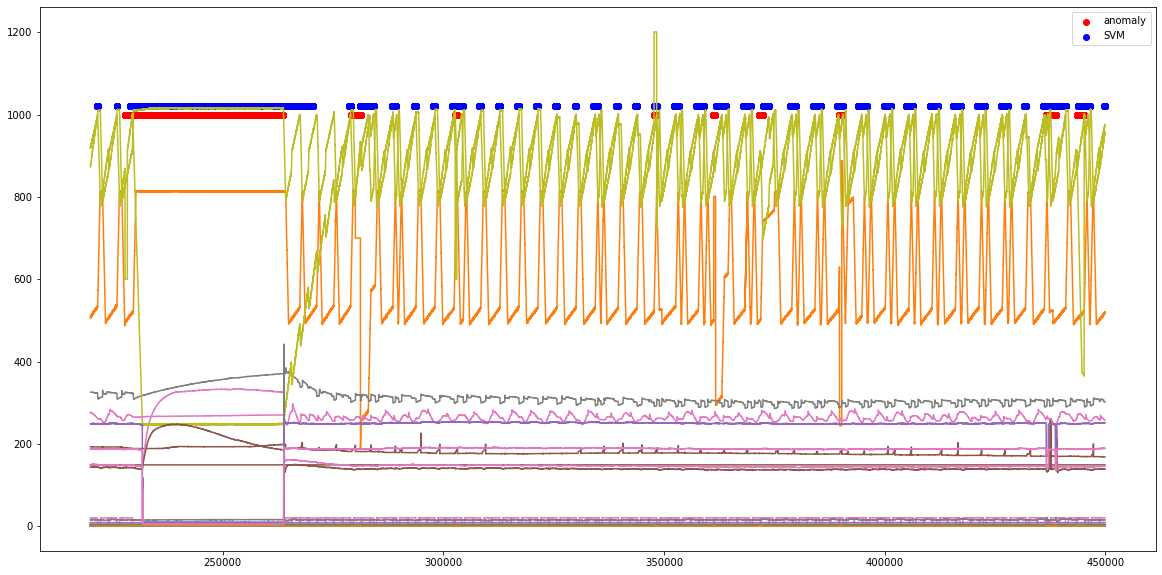

In [15]:
plt.figure(figsize = (20,10))

svm_anomaly_idxs = calc_anomaly_idxs(svm_predict, train_split_idx)
anomaly_idxs = anomaly_data.loc[train_split_idx:].index

plt.plot(raw_data[train_split_idx:])
plt.scatter(anomaly_idxs, 
            [1000]*len(anomaly_idxs), c='r', label='anomaly')
plt.scatter(svm_anomaly_idxs, 
            [1020]*len(svm_anomaly_idxs), c='blue', label='SVM')
plt.legend()
plt.show()

Модель показывает неплохой f1_score в основном за счет правильного определения длительной аномалии. Но если бы мы применили эту модель на онлайн данных, через некоторое время ей бы все перестали верить, т.к. она слишком часто бы обнаруживала несуществующие аномалии. Посмотрим, что модель покажет на всем датасете и только на тренировочной выборке

In [16]:
svm_predict = prepare_predict(svm.predict(normalized_data[:train_split_idx].values))
calc_score(label[:train_split_idx], svm_predict, 'SVM, тренировочная выборка')

SVM, тренировочная выборка
f1_score: 0.21
accuracy_score: 0.95
precision_score: 0.54
recall_score: 0.13


In [17]:
svm_predict = prepare_predict(svm.predict(normalized_data.values))
calc_score(label, svm_predict, 'SVM, все данные')

SVM, все данные
f1_score: 0.62
accuracy_score: 0.90
precision_score: 0.55
recall_score: 0.70


Нельзя просто доверять любой метрике, все сильно зависит от контекста. Посмотрим на картинку целиком

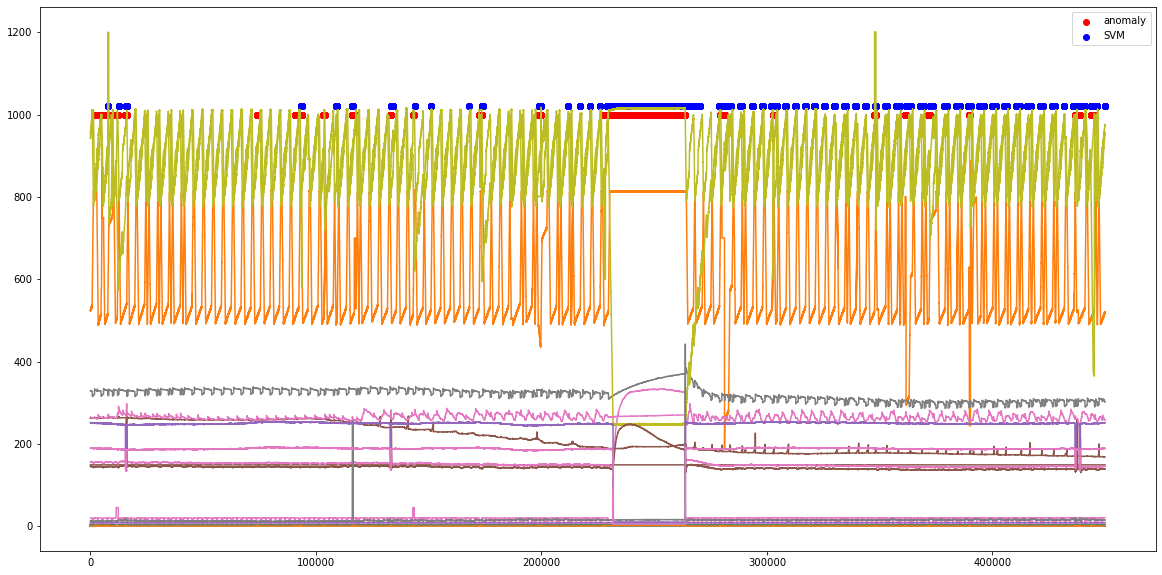

In [18]:
show_dataset_with_AD(svm_predict, "SVM")

Мы видим, что на тренировочной выборке модель почти не видит аномалий, или видит их не совсем там. После длительной аномалии модель наоборот определяет множество аномалий там, где их нет

**Вопрос**: за счет чего на тренировочной выборке F1 мера такая небольшая, ошибки какого рода преобладают в нашем случае?

**Ответ**: Низкая F1 мера является следствием низкого Recall, т.е. присутствует большое количество ложноотрицательных ответов (т.е. ошибка 2 рода), фактически это означает, что модель часто не распознает реальную аномалию.

**----Задание (возможное)----** На самом деле, данные слева и справа от длительной аномалии немного отличаются, поэтому наши оценки могут быть некорректными. Посмотрим, что будет, если подстроить гиперпараметр **nu** для SVM на тренировочной выборке для достижения лучшей метрики. Рекомендуем повышать f1_score, но вы можете сосредоточиться на других метриках, зависит от того, ошибка какого рода для вас важнее. Рекомендуем использовать диапазон 0.003 до 0.006, но вы можете его расширить, если позволяет ресурсы и время.

Обучите модель на разных **nu** и выберите оптимальный. Сравните результаты.

In [19]:
# SVM на таком количестве данных считается долго, поэтому сразу подставим результаты. Студенты могут экспериментировать
best_nu = 0.0046
best_gamma = 0.0008

# best_score = 0
# gamma = 0.0008

# for nu in range(30,60,2):
#     svm = OneClassSVM(nu=nu/10000, kernel="rbf", gamma=gamma, verbose=True)
#     svm.fit(x_train.values)
#     svm_predict = prepare_predict(svm.predict(normalized_data[:train_split_idx].values))

    
#     score = calc_score(label[:train_split_idx], svm_predict)['f1_score']
#     print(f'nu: {nu/10000:0.4f}, gamma: {gamma:0.4f}, f1_score: {score:0.2f}')
    
#     if score>best_score:
#         print('new winner!!',score)
#         best_gamma = gamma
#         best_nu = nu/10000
#         best_score=score

Подставим эти параметры в модель и посмотрим на результат на всей выборке

In [20]:
# svm = OneClassSVM(nu=best_nu, kernel="rbf", gamma=best_gamma, verbose=True)
# svm.fit(x_train.values)

In [21]:
# svm_predict = prepare_predict(svm.predict(normalized_data[:train_split_idx].values))
# calc_score(label[:train_split_idx], svm_predict, 'SVM, тренировочная выборка')

In [22]:
# svm_predict = prepare_predict(svm.predict(normalized_data.values))
# calc_score(label, svm_predict, 'SVM, все данные')

*Recall на тренировочной выборке вырос, но $F_1$ мера на всем датасете упала* - вариант вывода

In [23]:
# show_dataset_with_AD(svm_predict, "SVM")

После подбора $\nu$ стало намного больше ложно положительных аномалий во второй половине, хотя длительную аномалию алгоритм стал выявлять раньше. Принципиально лучше алгоритм работать не стал - вариант вывода

В итоге мы научились определять аномалии, но как подобрать оптимальные гиперпараметры модели без экспертного знания об аномалиях? Тем более что зачастую у нас есть только данные без аномалий. Мы продолжим двигаться в эту сторону.

# Самостоятельное задание: 
1. (обязательно) Посмотрите на распределение признаков, возможно некоторые из них стоит исключить из датасета, чтобы вычисления шли быстрее?
2. (обязательно) Попробуйте применить нормализацию данных только для сэмплов без аномалий, поменять тип нормализации
3. Попробуйте поэкспериментировать с настройками модели и разметкой датасета: посмотрите, как влияет на метрики изменение gamma, изменение места и размера тренировочной выборки.

Выкидывание лишних признаков и нормализация данных без аномалий (если студент ничего не сделал)

In [24]:
data.describe().T

,count,mean,std,min,25%,50%,75%,max
FIT101,449919.0,1.714346,1.191716,0.000000,0.000000,2.477020,2.577907,2.760145
LIT101,449919.0,607.019967,125.303003,189.826300,510.011100,530.422500,727.432100,925.032300
MV101,449919.0,1.665335,0.482323,0.000000,1.000000,2.000000,2.000000,2.000000
P101,449919.0,1.693251,0.461145,1.000000,1.000000,2.000000,2.000000,2.000000
P102,449919.0,1.006946,0.083051,1.000000,1.000000,1.000000,1.000000,2.000000
AIT201,449919.0,210.297302,35.157909,168.033800,177.102000,193.508100,253.845200,267.719800
AIT202,449919.0,8.528535,0.114844,6.000000,8.441618,8.551525,8.610806,8.733210
AIT203,449919.0,320.301478,16.631029,285.337100,306.383000,321.661100,331.684200,384.465500
FIT201,449919.0,1.702908,1.130277,0.000000,0.000000,2.446673,2.454362,2.826899
MV201,449919.0,1.691584,0.470611,0.000000,1.000000,2.000000,2.000000,2.000000


Уберем подозрительные данные, которые не меняются в течение времени наблюдения и нормализуем все остальные:

In [25]:
for column in data.columns:
    if data[column].std()==0: data = data.drop(column, axis=1)

Мы убрали 7 признаков, можно еще с чем-то поработать, но пока ограничимся этим. Но в практике следует уделять достаточно внимания самому датасету, т.к. по большому счету отбор признаков и EDA - один из важнейших этапов создания модели

In [26]:
# Нормализация на данных без аномалий и применение этой нормы к аномальным данным
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
scaler.fit(data.drop(anomaly_idxs, axis=0))
normalized_data =  pd.DataFrame(scaler.transform(data), columns=data.columns)

In [27]:
normalized_data.shape

(449919, 44)

## AutoEncoder

Autoencoder (автокодер, автоэнкодер, AE) — специальная архитектура искусственных нейронных сетей, позволяющая применять обучение без учителя при использовании метода обратного распространения ошибки. Простейшая архитектура автокодировщика — сеть прямого распространения, без обратных связей, наиболее схожая с перцептроном и содержащая входной слой, промежуточный слой и выходной слой. В отличие от перцептрона, выходной слой автокодировщика должен содержать столько же нейронов, сколько и входной слой.

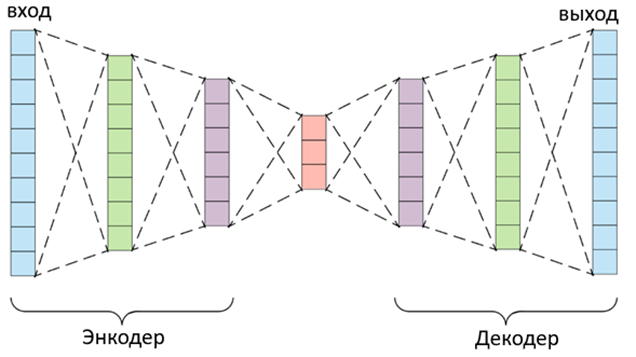

Автоэнкодер мы будем строить из LSTM ячеек. Общий вид ячейки:

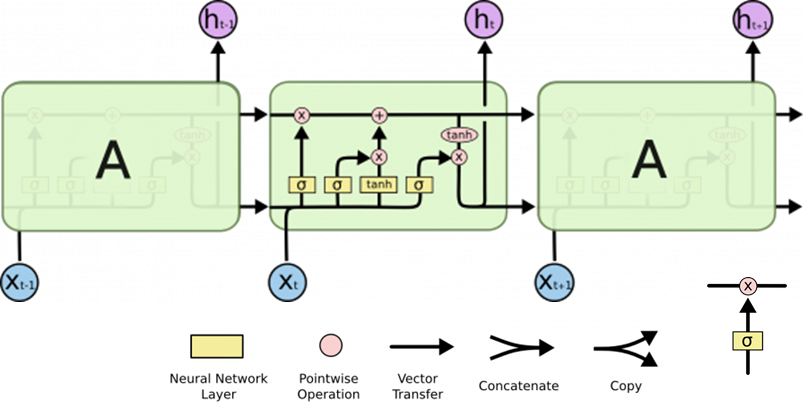

Поскольку мы будем использовать LSTM ячейки, для которых важна временная зависимость,мы возьмем предыдущий непрерывный участок без аномалий. Выберем такой участок.

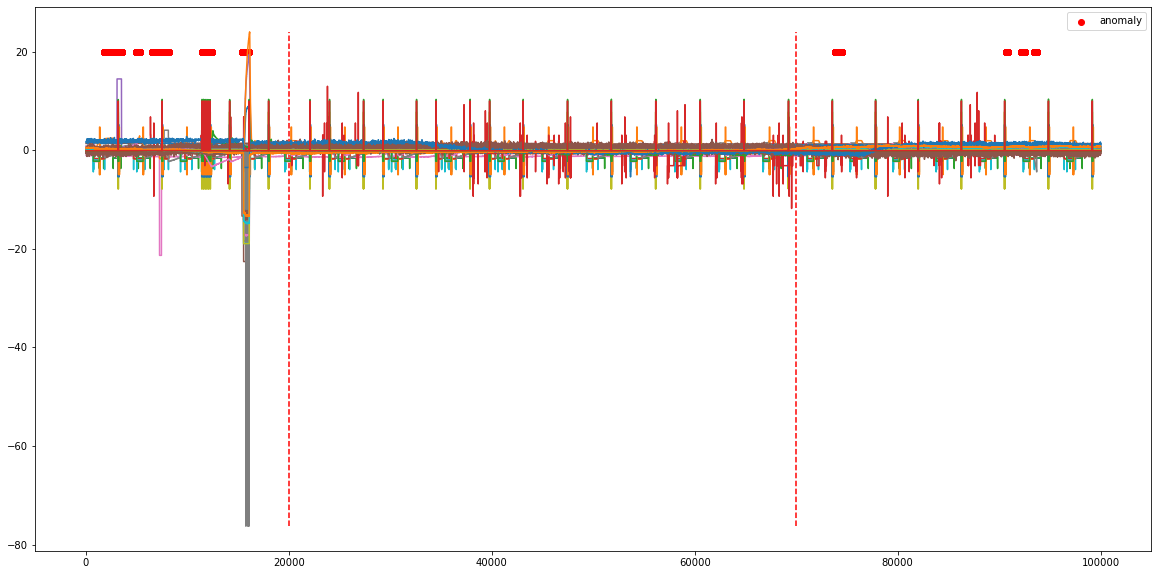

In [29]:
lim_left = 20_000
lim_right = 70_000

plt.figure(figsize = (20,10))

plt.plot(normalized_data[:100_000])
plt.scatter(anomaly_data.loc[:100_000].index,
            [20]*len(anomaly_data.loc[:100_000].index),c='r', label='anomaly')

# Границы участка без аномалий
plt.vlines([lim_left,lim_right], [normalized_data[:100_000].min().min()]*2, 
           [normalized_data[:100_000].max().max()]*2, colors='red', linestyles='dashed', label='')

plt.legend()
plt.show()

In [45]:
x_train = normalized_data.loc[lim_left:lim_right]
x_test = normalized_data.loc[train_split_idx:]

Мы должны подать на вход LSTM данные определенной размерности, для этого добавим к нашему датасету еще одну координату.

In [46]:
x_train_encoder = x_train.values.reshape((x_train.shape[0], x_train.shape[1], 1))
x_test_encoder = x_test.values.reshape((x_test.shape[0], x_test.shape[1], 1))
x_encoder = normalized_data.values.reshape((normalized_data.shape[0], normalized_data.shape[1], 1))

Построим сеть на LSTM ячейках, у которых количество нейронов на входном и выходном слое будет одинаковым

In [47]:
LSTM_AE = Sequential()
LSTM_AE.add(LSTM(64, return_sequences=True, activation='relu', 
                 input_shape=(x_train_encoder.shape[1], x_train_encoder.shape[2])))
LSTM_AE.add(LSTM(32, return_sequences=True, activation='relu'))
LSTM_AE.add(LSTM(16, return_sequences=True, activation='relu'))
LSTM_AE.add(LSTM(16, return_sequences=True, activation='relu'))
LSTM_AE.add(LSTM(32, return_sequences=True, activation='relu'))
LSTM_AE.add(LSTM(64, return_sequences=True, activation='relu'))
LSTM_AE.add(TimeDistributed(Dense(x_train_encoder.shape[2])))
LSTM_AE.compile(optimizer='adam', loss='mae')
LSTM_AE.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm (LSTM)                  (None, 44, 64)            16896     
_________________________________________________________________
lstm_1 (LSTM)                (None, 44, 32)            12416     
_________________________________________________________________
lstm_2 (LSTM)                (None, 44, 16)            3136      
_________________________________________________________________
lstm_3 (LSTM)                (None, 44, 16)            2112      
_________________________________________________________________
lstm_4 (LSTM)                (None, 44, 32)            6272      
_________________________________________________________________
lstm_5 (LSTM)                (None, 44, 64)            24832     
_________________________________________________________________
time_distributed (TimeDistri (None, 44, 1)             6

Учим модель

In [48]:
history = LSTM_AE.fit(x_train_encoder,
                      x_train_encoder,
                      epochs=15,
                      batch_size=100,
                      shuffle=False,
                      verbose=1)

Epoch 1/15
501/501 [==============================] - 34s 61ms/step - loss: 0.5019
Epoch 2/15
501/501 [==============================] - 31s 61ms/step - loss: 0.4971
Epoch 3/15
501/501 [==============================] - 31s 61ms/step - loss: 0.4967
Epoch 4/15
501/501 [==============================] - 31s 62ms/step - loss: 0.4935
Epoch 5/15
501/501 [==============================] - 31s 62ms/step - loss: 0.4901
Epoch 6/15
501/501 [==============================] - 30s 61ms/step - loss: 0.4907
Epoch 7/15
501/501 [==============================] - 31s 61ms/step - loss: 0.4857
Epoch 8/15
501/501 [==============================] - 31s 61ms/step - loss: 0.4787
Epoch 9/15
501/501 [==============================] - 31s 61ms/step - loss: 0.4278
Epoch 10/15
501/501 [==============================] - 31s 61ms/step - loss: 0.3178
Epoch 11/15
501/501 [==============================] - 31s 61ms/step - loss: 0.2952
Epoch 12/15
501/501 [==============================] - 31s 61ms/step - loss: 0.2856
E

Вычисляем ошибку на тренировочной выборке - это нам должно дать понимание порога, за которым начинаются аномалии

In [49]:
x_train_pred = LSTM_AE.predict(x_train_encoder)

In [50]:
train_mae_loss = np.mean(np.abs(x_train_pred - x_train_encoder), axis=1)

In [51]:
threshold = np.max(train_mae_loss)

Теперь применим нашу модель для тестовых данных и вычислим MAE.

Если на выбранном сэмпле MAE будет выше, чем заданный нами threshold, тогда будем считать этот сэмпл аномальным.

In [52]:
x_test_pred = LSTM_AE.predict(x_test_encoder)

In [53]:
test_mae_loss = np.mean(np.abs(x_test_pred - x_test_encoder), axis=1)
test_mae_loss = test_mae_loss.reshape((-1))

In [54]:
anomalies_encoder = test_mae_loss > threshold

In [55]:
calc_score(label[train_split_idx:], anomalies_encoder, 'AE, тест')

AE, тест
f1_score: 0.86
accuracy_score: 0.95
precision_score: 0.97
recall_score: 0.77


Пока все выглядит лучше, чем в предыдущих примерах, посмотрим на результаты на всей выборке

In [56]:
x_pred = LSTM_AE.predict(x_encoder)

In [57]:
mae_loss = np.mean(np.abs(x_pred - x_encoder), axis=1).reshape((-1))

In [58]:
ae_predict = mae_loss > threshold

In [59]:
calc_score(label, ae_predict, 'AE, все данные')

AE, все данные
f1_score: 0.76
accuracy_score: 0.95
precision_score: 0.97
recall_score: 0.62


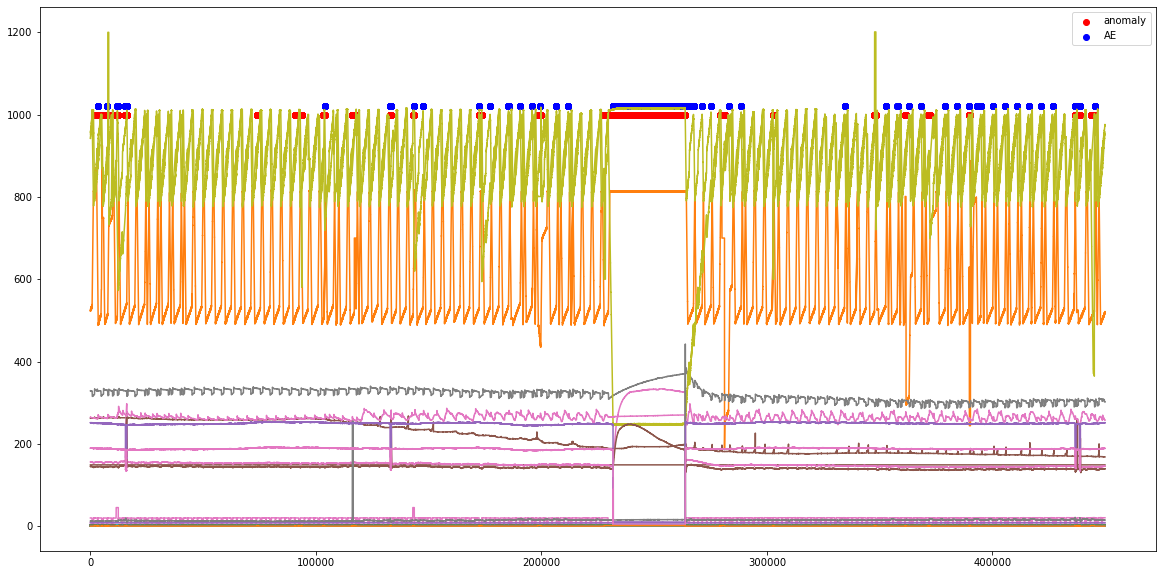

In [60]:
show_dataset_with_AD(ae_predict, "AE")

Автоэнкодер выявляет аномалии лучше, чем LOF, но с данным значением threshdold очень много ложноположительных сработок. С другой стороны, в отличие от One class SVM мы учили автоэнкодер на маленьком участке датасета, он может не знать о других режимах работы, которые являются нормой. Но при выявлении аномалий онлайн - это плюс, так как у обычно обучающая выборка практически не содержит аномалий.

**Самостоятельное задание** 
1. (обязательно) Попробуйте обучить автоэнкодер на другой выборке, например на той, на которой учили One class SVM. Возможно, аномалии в ней достаточно короткие и их исключение не даст некорректно обучить автоэнкодер. Сравните с изначальным результатом
2. Попробуйте использовать для обучения окна, когда на вход автоэнкодера будет подаваться батч из нескольких сэмплов

## SOM

Самоорганизу́ющаяся ка́рта Ко́хонена (англ. Self-organizing map — SOM) — нейронная сеть с обучением без учителя, выполняющая задачу визуализации и кластеризации. Идея сети предложена финским учёным Т. Кохоненом. Является методом проецирования многомерного пространства в пространство с более низкой размерностью (чаще всего, двумерное), применяется также для решения задач моделирования, прогнозирования, выявление наборов независимых признаков, поиска закономерностей в больших массивах данных, разработке компьютерных игр, квантизации цветов к их ограниченному числу индексов в цветовой палитре: при печати на принтере и ранее на ПК или же на приставках с дисплеем с пониженным числом цветов, для архиваторов [общего назначения] или видео-кодеков, и прч. Является одной из версий нейронных сетей Кохонена.

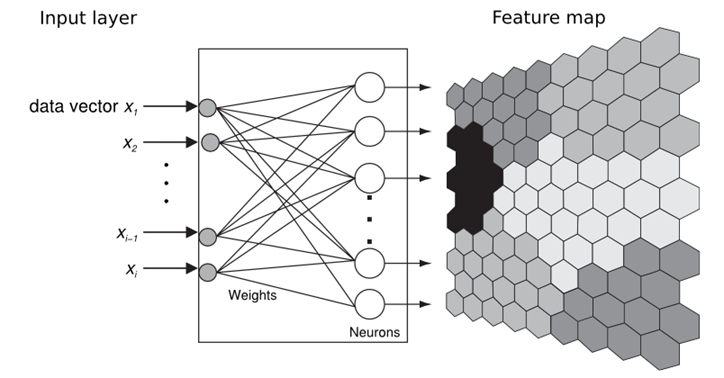

Для реализации используется библиотека minisom (https://github.com/JustGlowing/minisom). 

В качестве примера подхода взята статья Root-cause analysis through machine learning in the cloud (Tim Josefsson, Uppsala Universitet, Sweden): https://uu.diva-portal.org/smash/get/diva2:1178780/FULLTEXT01.pdf

In [61]:
from minisom import MiniSom

Мы также обучаем SOM на выборке без аномалий, но т.к. он не учитывает временные зависимости, мы можем учить его на всей тренировочной выборке

In [62]:
# Данные для обучения (без аномалий)
x_train = normalized_data.drop(anomaly_idxs, axis=0).loc[:train_split_idx]

# Данные для тестирования (с аномалиями)
x_test = normalized_data[train_split_idx:]
y_test = label[train_split_idx:]

In [63]:
som_train = MiniSom(8, 8, x_train.values.shape[1], sigma=2., learning_rate=0.5, 
              neighborhood_function='gaussian', random_seed=10)
som_train.pca_weights_init(x_train.values)
print("Training...")
som_train.train_batch(x_train.values, 50000, verbose=False)
print("\n...ready!")

Training...

...ready!


win_map покажет нам, как наша выборка разбилась на кластеры

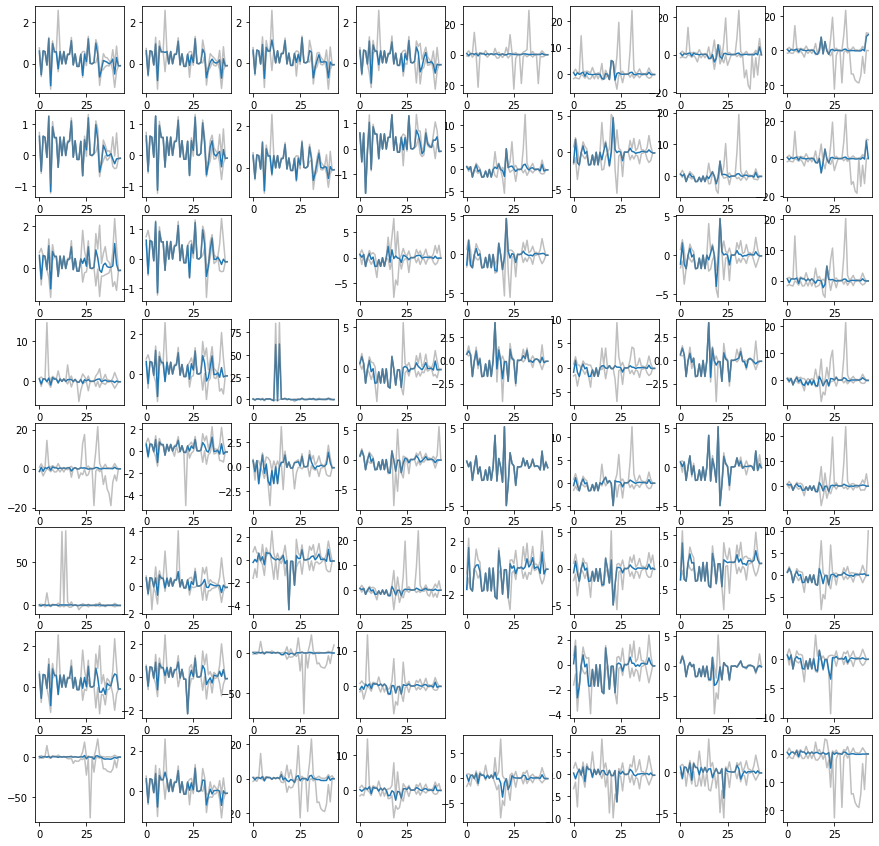

In [64]:
win_map = som_train.win_map(x_train.values)

plt.figure(figsize=(15, 15))
the_grid = GridSpec(8, 8)
for position in win_map.keys():
    plt.subplot(the_grid[position[0], position[1]])
    plt.plot(np.min(win_map[position], axis=0), color='gray', alpha=.5)
    plt.plot(np.mean(win_map[position], axis=0))
    plt.plot(np.max(win_map[position], axis=0), color='gray', alpha=.5)
plt.show()

Определим вспомогательные функции для рассчета размера окрестностей узлов SOM

In [1]:
def calc_SOM_neighbourhood_size(SOM):
# подсчет размера окрестности узлов SOM.
    
    SOM_size = SOM.get_weights().shape[:2]
    dist = np.zeros(SOM_size)

    for row in range(SOM_size[0]):
        for col in range(SOM_size[1]):
            M = SOM.get_weights()[row][col]

            dist_t = distance.cityblock(M,SOM.get_weights()[row-1][col]) if row>0 else 0
            dist_b = distance.cityblock(M,SOM.get_weights()[row+1][col]) if row<SOM_size[0]-1 else 0
            dist_l = distance.cityblock(M,SOM.get_weights()[row][col-1]) if col>0 else 0
            dist_r = distance.cityblock(M,SOM.get_weights()[row][col+1]) if col<SOM_size[1]-1 else 0

            dist[row][col] = dist_r + dist_l + dist_t + dist_b

    return dist

def calc_neighbourhood_size(SOM, X, useXvalues = False):
# подсчет размера окрестности узла-победителя

    SOM_size = SOM.get_weights().shape[:2]
    # получаем номер выигравшего узла, его координаты
    M = SOM.winner(X)
    row = M[0]
    col = M[1]

    # если мы хотим вместо весов победителя использовать значения исходного вектора
    if useXvalues:
        M = X
    else:
        M = SOM.get_weights()[row][col]

    dist_t = distance.cityblock(M,SOM.get_weights()[row-1][col]) if row>0 else 0
    dist_b = distance.cityblock(M,SOM.get_weights()[row+1][col]) if row<SOM_size[0]-1 else 0
    dist_l = distance.cityblock(M,SOM.get_weights()[row][col-1]) if col>0 else 0
    dist_r = distance.cityblock(M,SOM.get_weights()[row][col+1]) if col<SOM_size[1]-1 else 0


    return dist_r + dist_l + dist_t + dist_b

Рассчитаем размеры окрестности для SOM

In [66]:
dist = calc_SOM_neighbourhood_size(som_train)
dist_max = np.max(dist)
dist_max

67.68915769138253

Рассчитаем размеры окрестности для сэмплов тренировочной выборки - это может являться нашим порогом для выявления аномалий при RCA

In [67]:
neighbourhood_size_X_train = []
for i in tqdm(x_train.index): 
    X = normalized_data.values[i]  
    S = calc_neighbourhood_size(som_train, X, useXvalues = True)
    neighbourhood_size_X_train.append(S)

100%|██████████| 220001/220001 [00:09<00:00, 22723.56it/s]


In [68]:
threshold = max(neighbourhood_size_X_train)
threshold

874.0303231890902

Рассчитаем размеры окрестности для сэмплов всей выборки

In [69]:
neighbourhood_size_X = []
    
for i in tqdm(range(len(normalized_data.values))): 
    X = normalized_data.values[i]  
    S = calc_neighbourhood_size(som_train, X, useXvalues = True)
    neighbourhood_size_X.append(S)

100%|██████████| 449919/449919 [00:19<00:00, 22669.98it/s]


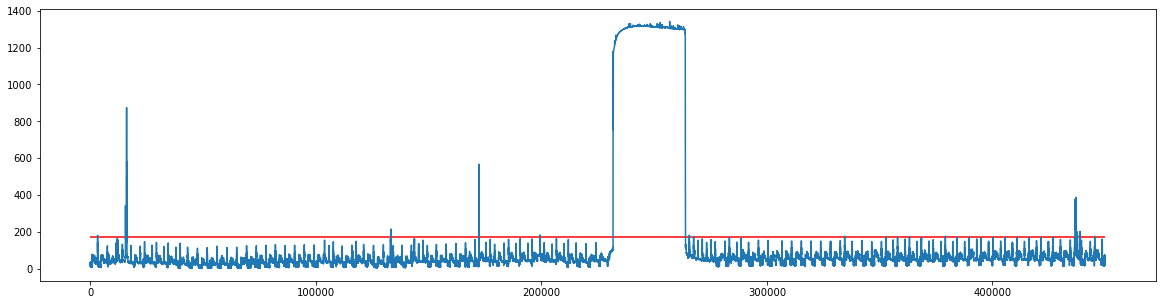

In [70]:
plt.figure(figsize = (20,5))
plt.plot(neighbourhood_size_X)
plt.hlines(170, 0, len(neighbourhood_size_X), color='red')
plt.show()

Мы будем определять аномалию при, если расстояние окрестности (neighbourhood_size) выше определенного порога. К сожалению, ни максимальное расстояние окрестностей узлов решетки SOM (43)не подходит. Возможно, разметка аномалий не очень корректная. Исходя из графика выше, предположим границу в районе 200

In [71]:
threshold = 170
som_predict = [1 if x>threshold else 0 for x in (neighbourhood_size_X)]

In [72]:
calc_score(label, som_predict, 'SOM, все данные')

SOM, все данные
f1_score: 0.76
accuracy_score: 0.95
precision_score: 0.99
recall_score: 0.61


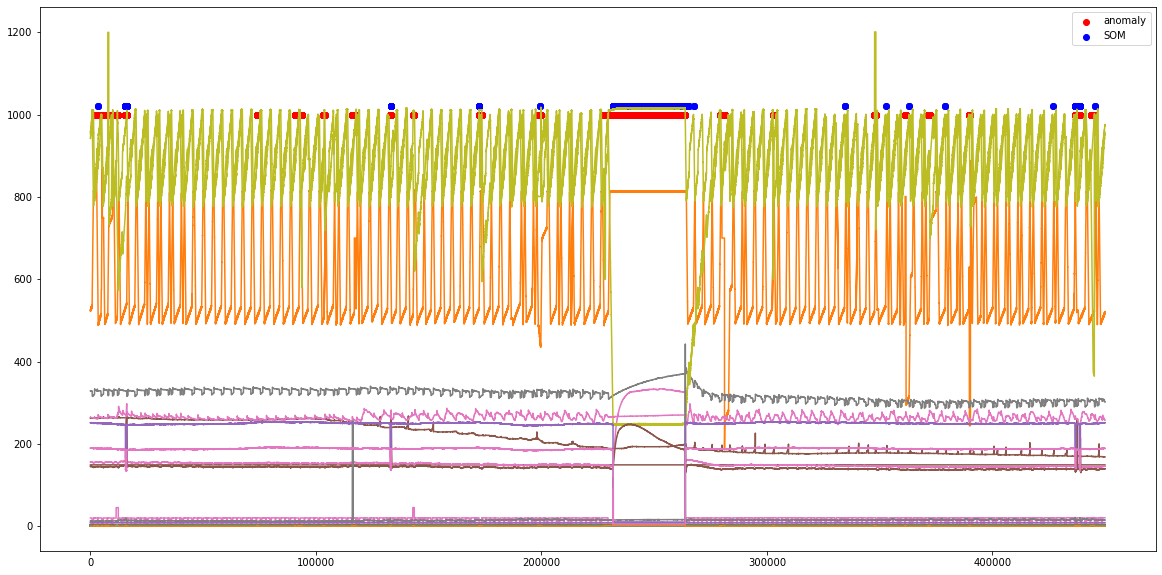

In [73]:
show_dataset_with_AD(som_predict, 'SOM')

Модель определяет аномалии чуть хуже, чем LSTM. Изменением порога можно добиться либо увеличения ложноположительных, либо ложноотрицательных ответов. Все зависит от поставленной задачи

**Самостоятельное задание** 
1. (обязательно) Попробуйте обучить SOM на другой выборке, например на той, на которой учили LSTM. Сравните с изначальным результатом
2. Попробуйте поэкспериментировать с гиперпараметрами модели: изменить количество узлов решетки, скорость обучения и т.п. Сравните с изначальным результатом

**Самостоятельное задание по теме "Выявление аномалий"** 
1. (обязательно) Составьте сводную таблицу по всем изученным моделям, где укажите название модели, ее параметры и полученные метрики.
2. Сделайте выводы, какая модель на Ваш взгляд наиболее корректно определяет аномалии на выбранном датасете

# Задания для самостоятельной работы

##  LOF

Локальный уровень выброса (Local Outlier Factor) – один из алгоритмов поиска аномалий, основанный на близости (Proximity-based). Это алгоритм кластеризации, имеющий общие концепции с DBSCAN и OPTICS, базирующийся на идее локальной плотности, которое в свою очередь использует определение «расстояния достижимости» (формулы локальной плотности и расстояния достижимости представлены на слайде). В отличие от других методов LOF позволяет выявлять выбросы при разных плотностях кластеров.
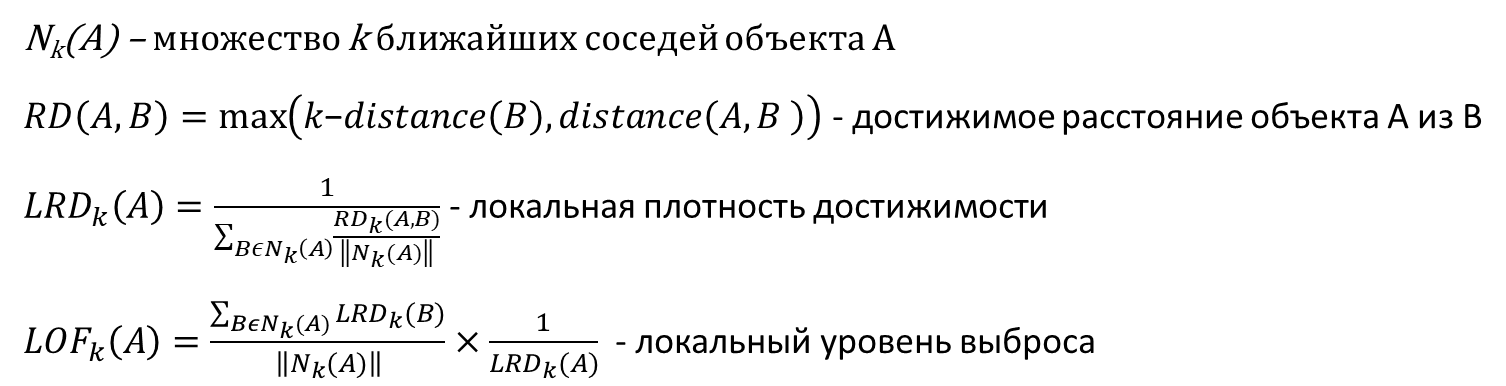

Алгоритм представлен в библиотеке Sklearn

Посмотрим, как этот алгоритм справится с нашими датасетами. Для начала нормализуем только неаномальные сэмплы (если вы не сделали этого раньше) *- этот участок кода выполнить в предыдущем самостоятельном задании (про нормализацию данных)*

In [28]:
# нормализация, если еще не сделана

LOF достаточно долго считается, поэтому мы будем обучать его на участке без аномалий. 

К тому же, для обучения автоэнкодера (следующий пункт) нам также понадобится непрерывный участок датасета. Выберем такой участок

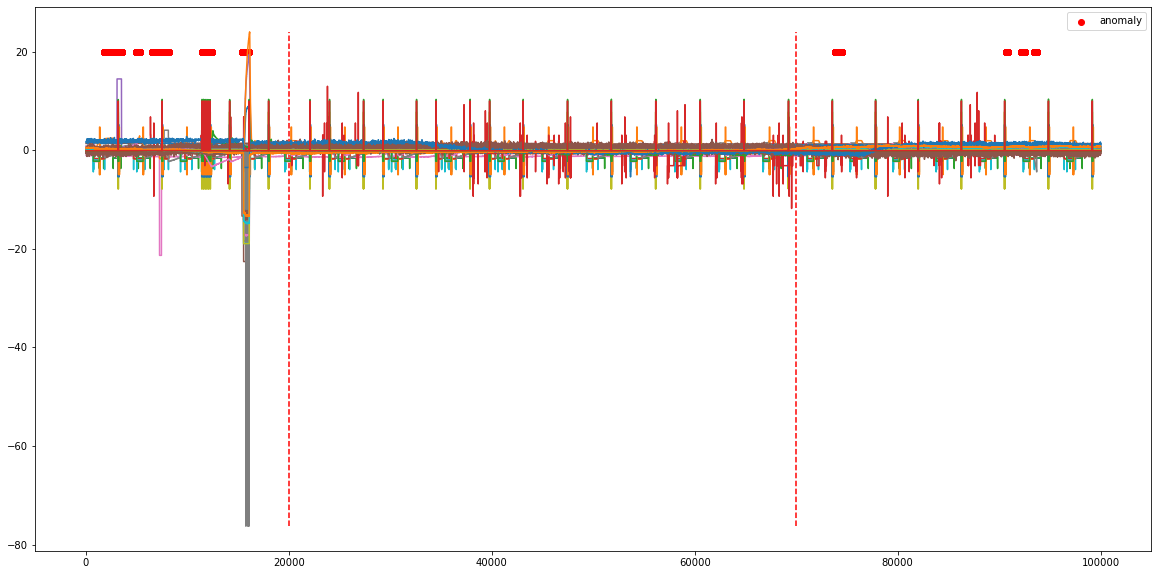

In [29]:
lim_left = 20_000
lim_right = 70_000

plt.figure(figsize = (20,10))

plt.plot(normalized_data[:100_000])
plt.scatter(anomaly_data.loc[:100_000].index,
            [20]*len(anomaly_data.loc[:100_000].index),c='r', label='anomaly')

# Границы участка без аномалий
plt.vlines([lim_left,lim_right], [normalized_data[:100_000].min().min()]*2, 
           [normalized_data[:100_000].max().max()]*2, colors='red', linestyles='dashed', label='')

plt.legend()
plt.show()

Применим к выбранному участку PCA, сократим размерность данных до 5

In [30]:
from sklearn.decomposition import PCA
X = normalized_data.loc[lim_left:lim_right]
pca = PCA(n_components=2)
principalComponents = pca.fit_transform(X)

x_train_pca = pd.DataFrame(data = principalComponents)

<AxesSubplot:>

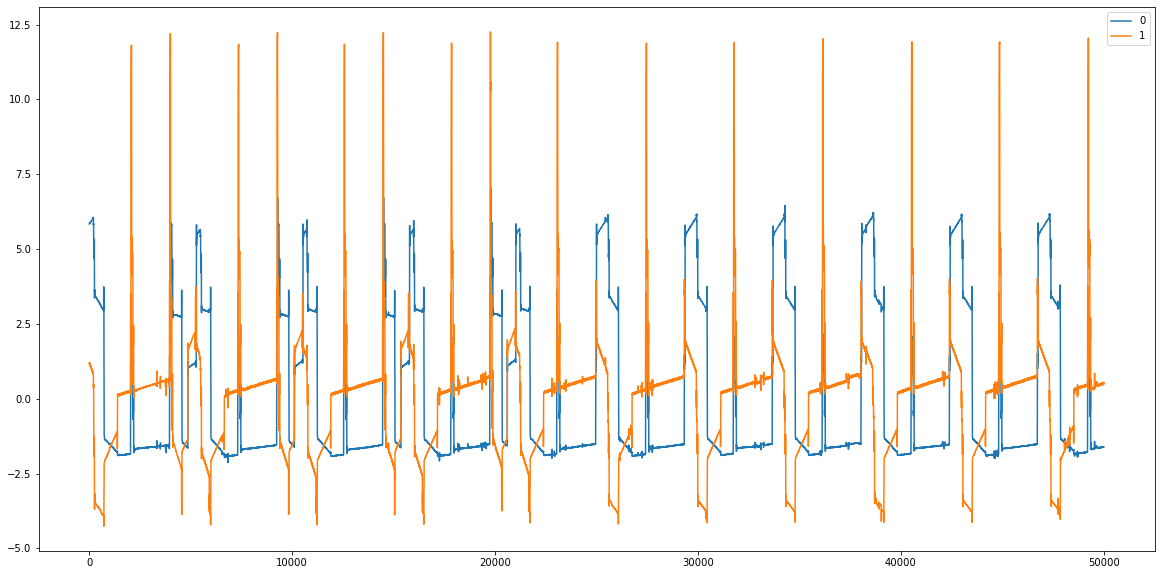

In [31]:
x_train_pca.plot(figsize=(20,10))

Теперь применим PCA ко всему датасету

In [32]:
x_pca = pd.DataFrame(pca.transform(normalized_data))

Уменьшение размерности также может позволить отобразить данные на плоскости

<AxesSubplot:xlabel='[1]', ylabel='[0]'>

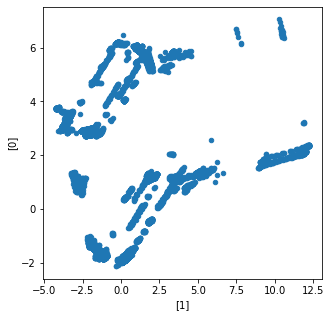

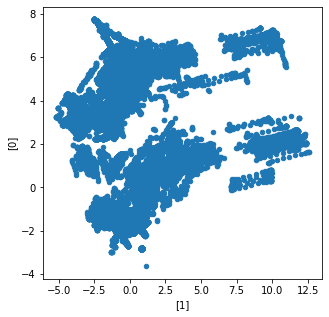

In [33]:
x_train_pca.plot.scatter(x=[1], y=[0], figsize=(5,5))
x_pca.plot.scatter(x=[1], y=[0], figsize=(5,5))

Тренируем модель LOF с параметром novelty = True, это указывает модели, что мы хотим выполнить не кластеризацию входных данных, а выявление аномалий для других данных, но на этой модели

In [34]:
lof = LocalOutlierFactor(novelty=True, n_jobs=-1, n_neighbors=5)

In [35]:
lof.fit(x_train_pca)

LocalOutlierFactor(n_jobs=-1, n_neighbors=5, novelty=True)

In [36]:
lof_predict = prepare_predict(lof.predict(x_pca))
calc_score(label, lof_predict, 'LOF, тестовая выборка')

LOF, тестовая выборка
f1_score: 0.27
accuracy_score: 0.39
precision_score: 0.16
recall_score: 0.92


Значения локального уровня выброса можно получить из обученной модели:

In [37]:
lof_score = lof.score_samples(x_pca)

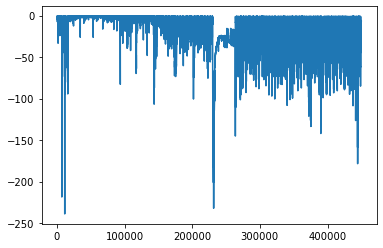

In [38]:
plt.plot(lof_score)
plt.show()

Посмотрим на предсказания модели на тренировочном участке отметим границу, ниже которой LOF не снижается

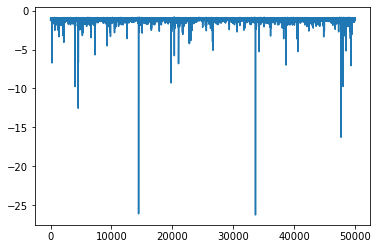

Минимальное значение lof_score: -26.274978609139986


In [39]:
plt.plot(lof_score[lim_left:lim_right])
plt.show()
threshold_train = min(lof_score[lim_left:lim_right])
print('Минимальное значение lof_score:', min(lof_score[lim_left:lim_right]))

In [40]:
best_score = 0
best_threshold = 0

for threshold in range(-50,-10): 
    lof_predict = [1 if x<threshold else 0 for x in (lof_score)]
    score = calc_score(label, lof_predict)['f1_score']
    
    if score > best_score:
        best_score = score
        best_threshold = threshold
best_threshold

-24

Видим, что лучший показатель трешхолда для F1_score почти совпадает с границей, которую мы вывели из тренировочного датасета. Возьмем threshold_train за основу

In [41]:
threshold = threshold_train

In [42]:
lof_predict = [1 if x<threshold else 0 for x in (lof_score)]

In [43]:
# lof_predict = prepare_predict(lof.predict(normalized_data.values))
calc_score(label, lof_predict, 'LOF, все данные')

LOF, все данные
f1_score: 0.48
accuracy_score: 0.86
precision_score: 0.44
recall_score: 0.54


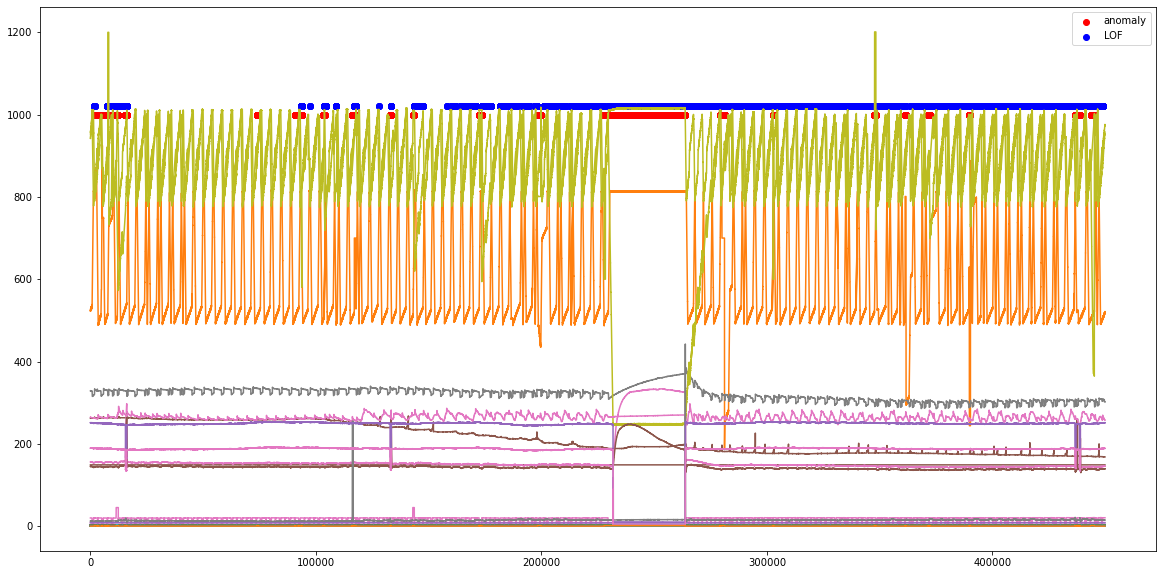

In [44]:
show_dataset_with_AD(lof_predict, "LOF")

Как мы видим, LOF недостаточно хорошо справляется со своей задачей. Возможно, это следствие того, что тренировочная выборка недостаточно отражает все возможные нормальные состояния системы

**Самостоятельное задание:** 
попробуйте поэкспериментировать с настройками модели, размером и разметкой датасета.

https://scikit-learn.org/stable/modules/generated/sklearn.neighbors.LocalOutlierFactor.html

https://scikit-learn.org/stable/auto_examples/neighbors/plot_lof_novelty_detection.html#sphx-glr-auto-examples-neighbors-plot-lof-novelty-detection-py

## Корневой анализ причин

Корневой анализ причин будет производиться методом, основанном на подходе, предложенном в ранее упомянутой статье Root-cause analysis through machine learning in the cloud. Мы будем анализировать каждый сэмпл исходного датасета на предмет его принадлежности к одному из кластеров. Если расстояние до узлов SOM будет большим, значит это аномальный сэмпл. Если аномальных сэмплов становится много, то мы запускаем механизм RCA и ищем, какой из параметров наиболее сильно повлиял на увеличение расстояния до узлов решетки.

In [2]:
def calc_dissimilarity_vectors(SOM, X, threshold, useXvalues, N=3):
# расчет векторов dissimirarity
    SOM_size = SOM.get_weights().shape[:2]
    dist = calc_SOM_neighbourhood_size(SOM)
    winner_idx = SOM.winner(X)
    dissimilarity = np.zeros(len(X))
    
    idxs = np.unravel_index(np.argsort(dist, axis=None), dist.shape)
    dissimilarity_vectors = []
    i = 0
    
    while i<N and i<len(idxs):
        # Если нейрон помечен как аномальный, то пропускаем его
        if dist[idxs[0][i]][idxs[1][i]]>threshold and useXvalues==False:
            N += 1
        else:
            diff = X - SOM.get_weights()[idxs[0][i]][idxs[1][i]]
            dissimilarity_vectors.append(list(diff))
        i += 1

    for i in range(len(dissimilarity_vectors)):
        dissimilarity = dissimilarity + np.array(dissimilarity_vectors[i])
        print("Наиболее вероятные параметры:", np.argsort(dissimilarity)[-3:])
    
    if len(dissimilarity_vectors) == 0:
        print('There are no healthy nodes')

    
    return dissimilarity

In [74]:
dissimilarity_X = []
anomaly_cnt = 0
anomaly_cnt_threshold = 10 # счетчик аномалий, при достижении которого запустится RCA
anomaly_dist_threshold = threshold # порог выявления аномального расстояния 

# поскольку нам интересно, что случилось причиной длительной аномалии, начнем сразу с 200 тысячного сэмпла
RCA_data = normalized_data[200_000:]

for i in tqdm(range(RCA_data.shape[0])):
    
    X = RCA_data.values[i] #новый сэмпл     

    S = calc_neighbourhood_size(som_train, X, useXvalues=True) # размер окрестности


    if S > anomaly_dist_threshold:
        anomaly_cnt += 1

        if anomaly_cnt == anomaly_cnt_threshold: # если аномалий много, применяем RCA
            print(i, S,'starting RCA...')
            calc_dissimilarity_vectors(som_train, X, anomaly_dist_threshold, useXvalues=True, N=8)
            break

 13%|█▎        | 31765/249919 [00:01<00:09, 22312.96it/s]

31765 1043.0511328397208 starting RCA...
Наиболее вероятные параметры: [ 6  1 21]
Наиболее вероятные параметры: [ 6  1 21]


Модель выдала результаты в виде индексов самых главных виновников аномалии.

In [75]:
normalized_data.iloc[:,6].name, normalized_data.iloc[:,21].name, normalized_data.iloc[:,1].name

('AIT202', 'MV304', 'LIT101')

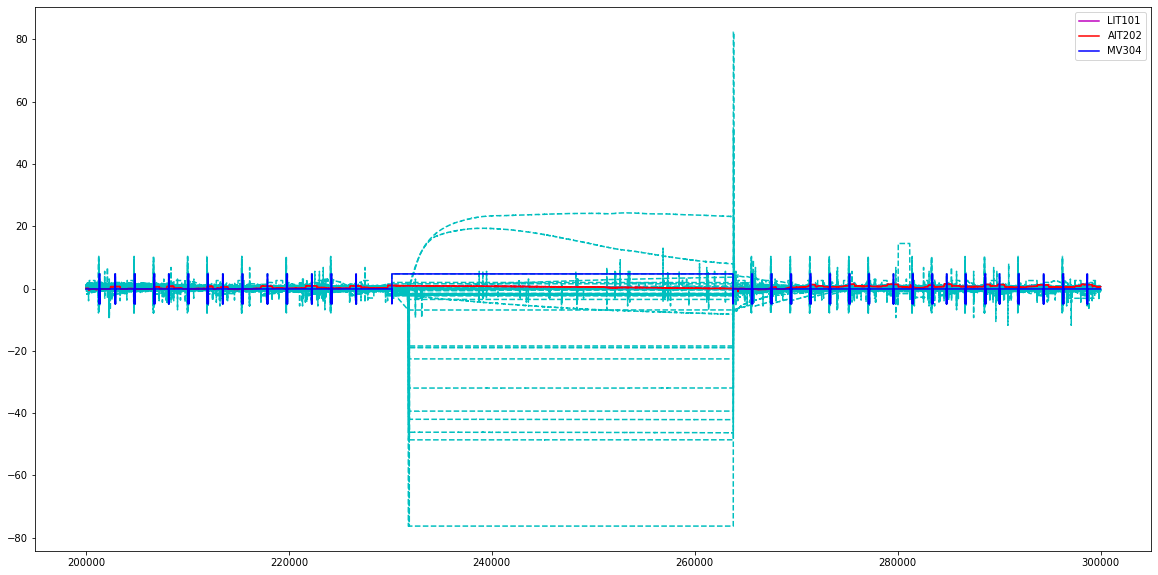

In [76]:
plt.figure(figsize=(20,10))
plt.plot(normalized_data[200_000:300_000],'--c')
plt.plot(normalized_data[200_000:300_000].iloc[:,6],'m', label=normalized_data.iloc[:,1].name)
plt.plot(normalized_data[200_000:300_000].iloc[:,6],'r', label=normalized_data.iloc[:,6].name)
plt.plot(normalized_data[200_000:300_000].iloc[:,21],'b', label=normalized_data.iloc[:,21].name)
plt.legend()
plt.show()

Таким образом, наша модель посчитала, что в произошедшем следует винить MV304, LIT101 и AIT202.